W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 사용 폰트: NanumGothic


/tmp/ipython-input-3449846218.py:58: UserWarning: Glyph 10004 (\N{HEAVY CHECK MARK}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10004 (\N{HEAVY CHECK MARK}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


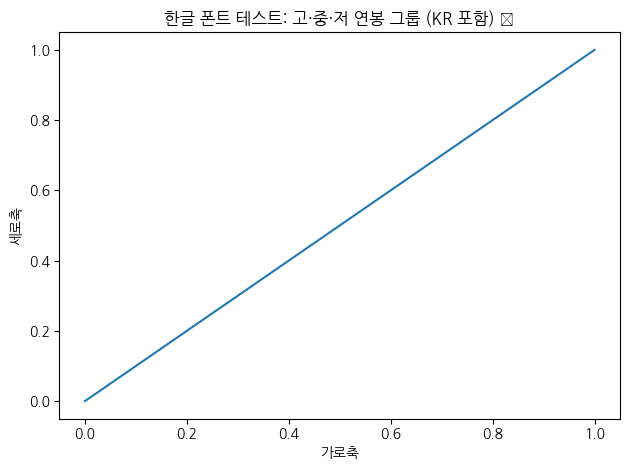

In [ ]:
# =====================================================
# ✅ Colab 한글 폰트 완전 고정 템플릿 (자동 탐지·자동 선택)
# 런타임 세션 다시 시작후 코드 입력
# =====================================================
!apt-get update -qq > /dev/null
!apt-get install -y fonts-noto-cjk fonts-nanum > /dev/null
!fc-cache -fv > /dev/null

import os, glob, shutil
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1) matplotlib 폰트 캐시 폴더 보장 + 기존 캐시 파일 정리
cache_dir = os.path.join(os.path.expanduser("~"), ".cache", "matplotlib")
os.makedirs(cache_dir, exist_ok=True)
for f in glob.glob(os.path.join(cache_dir, "fontlist-*.json*")):
    try:
        os.remove(f)
    except FileNotFoundError:
        pass

# 2) 시스템 폰트 목록 새로 읽기
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')  # 있으면 등록
# (Noto CJK는 패키지 설치 시 자동 등록됨)

# 3) 사용 가능한 한글 폰트 자동 탐지
candidates = [
    "NanumGothic",
    "Noto Sans CJK KR",   # 권장
    "Noto Sans CJK",      # 일부 배포판에서 이 이름으로만 잡힐 수 있음
    "Noto Sans CJK SC",   # 혹시 중국어 패키지만 깔렸을 때 대체
]
available = {f.name for f in fm.fontManager.ttflist}
chosen = None
for name in candidates:
    if any(name == a or name in a for a in available):
        chosen = name
        break
if chosen is None:
    chosen = "DejaVu Sans"  # 최후의 안전장치(한글 미지원)

# 4) 전역 폰트 설정 (FontProperties 객체 사용 안 함 → TypeError 예방)
plt.rcParams.update({
    "font.family": chosen,
    "font.sans-serif": [chosen],
    "axes.unicode_minus": False,
    "font.size": 10,
})

print("✅ 사용 폰트:", chosen)
# 간단 테스트
plt.figure()
plt.title("한글 폰트 테스트: 고·중·저 연봉 그룹 (KR 포함) ✔")
plt.plot([0,1],[0,1])
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
# 파일 불러오기
# 사용하는 환경에 따라 주석처리 해서 사용
# df = pd.read_csv("C:/Users/user/ai_job/ai_job_market.csv") # 주피터 용
df = pd.read_csv("/content/ai_job_market.csv") # 코랩 용
# 코랩에서 사용할때는 csv파일 업로드 해주셔야 합니다.

# 전처리
'''
컬럼 지정, salary_range_usd "-" 뒤의 값 삭제, posted_date 날짜 삭제, location ','앞의 값 삭제(도시 제거),
skills_required, tools_preferred 리스트 화, experience_level, employment_type, company_size 코드 지정
'''
# 사용할 컬럼 지정
use_cols = (['industry', 'job_title', 'skills_required',
       'experience_level', 'employment_type', 'location', 'salary_range_usd',
       'posted_date', 'company_size', 'tools_preferred'])
df = df[use_cols].copy()

# salary_range_usd "-" 뒤의 값 삭제 - 앞의 숫자 초봉이라 가정
df['salary_range_usd'] = df['salary_range_usd'].str.replace('-[^-]*$', '', regex=True)

# posted_date 날짜 삭제
df['posted_date'] = df['posted_date'].str.replace('-[^-]*$', '', regex=True)

# location ','앞의 값 삭제(도시 제거)
df['location'] = df['location'].str.replace('.*,', '', regex=True)

# skills_required 리스트 화
df['skills_required'] = (
    df['skills_required']
    .dropna()       # 결측치 제거
    .apply(lambda x: [skill.strip() for skill in x.split(',')])  # 공백 제거 후 리스트화
)

# tools_preferred 리스트 화
df['tools_preferred'] = (
    df['tools_preferred']
    .dropna()       # 결측치 제거
    .apply(lambda x: [skill.strip() for skill in x.split(',')])  # 공백 제거 후 리스트화
)

# experience_level 코드화 {Entry(신입): 0, Mid(경력): 1, Senior(시니어): 3}
df["experience_level"] = df["experience_level"].map({"Entry": 0, "Mid": 1, 'Senior': 2})

# employment_type 코드화 {Contract(계약직): 0, Remote(프리렌서): 1, Internship(인턴십): 2, , Full-time(정규직): 3}
df["employment_type"] = df["employment_type"].map({"Contract": 0, "Remote": 1, 'Internship': 2, 'Full-time': 3})

# company_size 코드화 {Startup(스타트업): 0, Mid(중소기업): 1, Large(대기업): 2}
df['company_size'] = le.fit_transform(df['company_size'])

df['industry'] = le.fit_transform(df['industry'])
df['job_title'] = le.fit_transform(df['job_title'])
df['location'] = le.fit_transform(df['location'])
# df['skills_required'] = le.fit_transform(df['skills_required'])

df.to_csv("/content/ai_job_market_clean.csv")

display(df)
df.info()

,industry,job_title,skills_required,experience_level,employment_type,location,salary_range_usd,posted_date,company_size,tools_preferred
0,4,3,"[NumPy, Reinforcement Learning, PyTorch, Sciki...",1,3,7,92860,2025-08,0,"[KDB+, LangChain]"
1,6,2,"[Scikit-learn, CUDA, SQL, Pandas]",2,3,39,78523,2024-03,0,"[FastAPI, KDB+, TensorFlow]"
2,6,7,"[MLflow, FastAPI, Azure, PyTorch, SQL, GCP]",0,3,35,124496,2025-09,0,"[BigQuery, PyTorch, Scikit-learn]"
3,6,0,"[Scikit-learn, C++, Pandas, LangChain, AWS, R]",1,3,55,50908,2024-05,0,"[TensorFlow, BigQuery, MLflow]"
4,3,4,"[Excel, Keras, SQL, Hugging Face]",2,0,126,98694,2025-02,0,"[PyTorch, LangChain]"
...,...,...,...,...,...,...,...,...,...,...
1995,3,6,"[Flask, FastAPI, Power BI]",2,2,153,90382,2024-04,0,[MLflow]
1996,0,0,"[R, Flask, Excel, C++, CUDA, Scikit-learn]",1,1,192,47848,2023-12,0,"[KDB+, LangChain, MLflow]"
1997,2,3,"[Hugging Face, Excel, Scikit-learn, R, MLflow]",0,0,31,134994,2023-10,0,[PyTorch]
1998,2,7,"[AWS, Python, Scikit-learn]",2,0,134,62388,2024-08,0,"[MLflow, TensorFlow, FastAPI]"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   industry          2000 non-null   int64 
 1   job_title         2000 non-null   int64 
 2   skills_required   2000 non-null   object
 3   experience_level  2000 non-null   int64 
 4   employment_type   2000 non-null   int64 
 5   location          2000 non-null   int64 
 6   salary_range_usd  2000 non-null   object
 7   posted_date       2000 non-null   object
 8   company_size      2000 non-null   int64 
 9   tools_preferred   2000 non-null   object
dtypes: int64(6), object(4)
memory usage: 156.4+ KB


⚠️ CatBoost가 설치되지 않았습니다. pip install catboost 로 설치하세요.

🚀 [LinearRegression] 모델 학습 시작...
✅ LinearRegression 완료 | R²=-0.112, RMSE=35391.3, 시간=0.0s

🚀 [RandomForest] 모델 학습 시작...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


✅ RandomForest 완료 | R²=-0.057, RMSE=34497.3, 시간=1.9s

🚀 [XGBoost] 모델 학습 시작...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


✅ XGBoost 완료 | R²=-0.108, RMSE=35321.0, 시간=0.3s

📊 모델별 성능 비교 결과:
              Model        R2          RMSE   Time(s)
1      RandomForest -0.056553  34497.324674  1.864653
2           XGBoost -0.107608  35320.990247  0.267200
0  LinearRegression -0.112024  35391.324151  0.032303


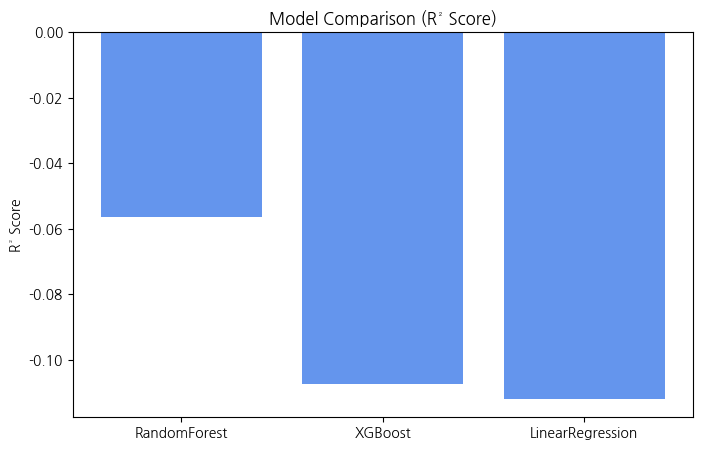

In [35]:
# ===============================
# 🔥 고성능 모델 비교 + 진척도 표시
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# CatBoost는 verbose 제한 버전으로 import
try:
    from catboost import CatBoostRegressor
    catboost_available = True
except:
    catboost_available = False
    print("⚠️ CatBoost가 설치되지 않았습니다. pip install catboost 로 설치하세요.")

# ===============================
# 1. 데이터 준비
# ===============================
df = pd.read_csv("ai_job_market_clean.csv")
df_sample = df.sample(800, random_state=42)

X = df_sample[['industry', 'job_title', 'skills_required', 'experience_level', 'employment_type']]
y = df_sample['salary_range_usd']

# ===============================
# 2. 전처리 정의
# ===============================
vectorizer = CountVectorizer(
    tokenizer=lambda x: x.strip("[]").replace("'", "").split(','),
    max_features=120
)
preprocessor = ColumnTransformer([('skills', vectorizer, 'skills_required')], remainder='passthrough')

# ===============================
# 3. 모델 구성
# ===============================
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=150, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=250, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
}

if catboost_available:
    models["CatBoost"] = CatBoostRegressor(
        depth=8, learning_rate=0.05, iterations=300,
        random_state=42, verbose=50
    )

# ===============================
# 4. 학습 및 평가
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = []

for name, model in models.items():
    print(f"\n🚀 [{name}] 모델 학습 시작...")
    start = time.time()

    pipeline = Pipeline([
        ('pre', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    duration = time.time() - start

    print(f"✅ {name} 완료 | R²={r2:.3f}, RMSE={rmse:.1f}, 시간={duration:.1f}s")
    results.append((name, r2, rmse, duration))

# ===============================
# 5. 결과 시각화
# ===============================
results_df = pd.DataFrame(results, columns=["Model", "R2", "RMSE", "Time(s)"]).sort_values(by="R2", ascending=False)
print("\n📊 모델별 성능 비교 결과:")
print(results_df)

plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["R2"], color="cornflowerblue")
plt.title("Model Comparison (R² Score)")
plt.ylabel("R² Score")
plt.show()

# ===============================
# 6. CatBoost Feature Importance
# ===============================
if catboost_available:
    print("\n🔍 CatBoost 중요도 시각화:")
    cb_model = models["CatBoost"]
    feature_importances = cb_model.get_feature_importance()
    feature_names = list(vectorizer.get_feature_names_out()) + ['industry','job_title','experience_level','employment_type']

    sorted_idx = np.argsort(feature_importances)[-10:][::-1]
    plt.figure(figsize=(8,5))
    plt.barh(np.array(feature_names)[sorted_idx], feature_importances[sorted_idx], color="salmon")
    plt.title("CatBoost Top 10 Feature Importances")
    plt.gca().invert_yaxis()
    plt.show()


✅ 데이터 로드 완료: (2000, 11)
   Unnamed: 0  industry  job_title  \
0           0         4          3   
1           1         6          2   
2           2         6          7   

                                     skills_required  experience_level  \
0  ['NumPy', 'Reinforcement Learning', 'PyTorch',...                 1   
1          ['Scikit-learn', 'CUDA', 'SQL', 'Pandas']                 2   
2  ['MLflow', 'FastAPI', 'Azure', 'PyTorch', 'SQL...                 0   

   employment_type  location  salary_range_usd posted_date  company_size  \
0                3         7             92860     2025-08             0   
1                3        39             78523     2024-03             0   
2                3        35            124496     2025-09             0   

                           tools_preferred  
0                    ['KDB+', 'LangChain']  
1        ['FastAPI', 'KDB+', 'TensorFlow']  
2  ['BigQuery', 'PyTorch', 'Scikit-learn']  

🚀 CatBoost 전체 데이터 학습 시작...
0:	learn: 316

/tmp/ipython-input-3095581592.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['skills_required'] = X['skills_required'].astype(str).apply(lambda x: x.strip("[]").replace("'", ""))


100:	learn: 29655.4056764	test: 32581.0710212	best: 32556.0173369 (96)	total: 453ms	remaining: 4.03s
200:	learn: 26452.2161964	test: 32614.0499438	best: 32521.6568805 (163)	total: 1.02s	remaining: 4.07s
300:	learn: 23813.1521074	test: 32641.0149606	best: 32521.6568805 (163)	total: 1.63s	remaining: 3.79s
400:	learn: 21676.1131492	test: 32739.1058067	best: 32521.6568805 (163)	total: 2.21s	remaining: 3.3s
500:	learn: 19914.4234707	test: 32809.9413613	best: 32521.6568805 (163)	total: 2.81s	remaining: 2.8s
600:	learn: 18464.8610137	test: 32863.2318344	best: 32521.6568805 (163)	total: 3.43s	remaining: 2.28s
700:	learn: 16936.1360325	test: 32902.9375642	best: 32521.6568805 (163)	total: 4.76s	remaining: 2.03s
800:	learn: 15852.9951208	test: 32946.6918923	best: 32521.6568805 (163)	total: 6.07s	remaining: 1.51s
900:	learn: 14642.7102890	test: 33046.0299007	best: 32521.6568805 (163)	total: 6.73s	remaining: 740ms
999:	learn: 13446.1780294	test: 33101.3446786	best: 32521.6568805 (163)	total: 7.33s	

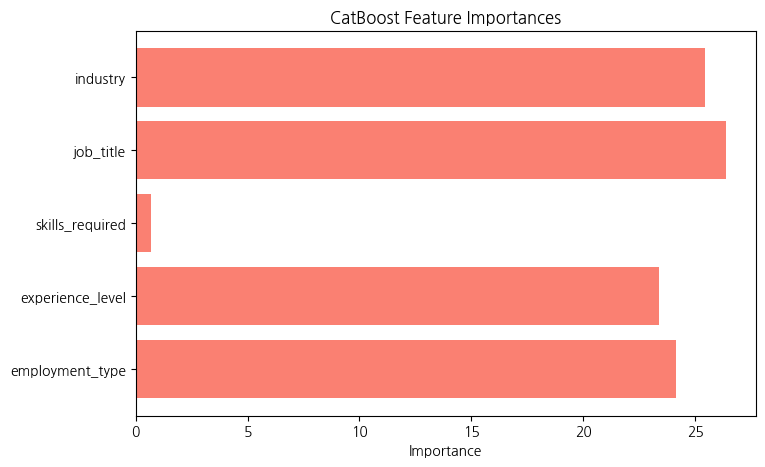


📈 실제 급여 vs 예측 급여 상위 10개:


,Actual,Predicted
0,121766,91964.089101
1,71489,95946.035286
2,40044,91407.825668
3,90596,86510.748367
4,114993,93682.403708
5,85034,92006.406687
6,66473,88883.809500
7,127211,95309.312235
8,106117,95035.310333
9,56407,95355.765535


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Actual'].plot(kind='hist', bins=20, title='Actual')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Predicted'].plot(kind='hist', bins=20, title='Predicted')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='Actual', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Actual', y='Predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Actual']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Actual')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Predicted']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Predicted')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Actual'].plot(kind='line', figsize=(8, 4), title='Actual')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Predicted'].plot(kind='line', figsize=(8, 4), title='Predicted')
plt.gca().spines[['top', 'right']].set_visible(False)

In [38]:
# 요소 별 중요도


# ===============================================
# 1️⃣ 라이브러리 설치 및 불러오기
# ===============================================
# (Colab에서는 다음 줄 실행, Jupyter/Anaconda에서는 생략 가능)
# !pip install catboost scikit-learn matplotlib pandas numpy -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# ===============================================
# 2️⃣ 데이터 로드
# ===============================================
df = pd.read_csv("ai_job_market_clean.csv")
print("✅ 데이터 로드 완료:", df.shape)
print(df.head(3))

# ===============================================
# 3️⃣ 입력(X)과 타깃(y) 설정 (전체 데이터 사용)
# ===============================================
X = df[['industry', 'job_title', 'skills_required', 'experience_level', 'employment_type']]
y = df['salary_range_usd']

# 문자열 정제 (리스트형 문자열을 일반 문자열로 변환)
X['skills_required'] = X['skills_required'].astype(str).apply(lambda x: x.strip("[]").replace("'", ""))

# ===============================================
# 4️⃣ 학습/검증 데이터 분리
# ===============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===============================================
# 5️⃣ CatBoost 모델 구성
# ===============================================
model = CatBoostRegressor(
    depth=8,               # 트리 깊이
    learning_rate=0.05,    # 학습률
    iterations=1000,       # 반복 횟수 (전체 데이터 학습에 적합)
    random_seed=42,
    verbose=100,           # 100단계마다 학습 진행 상황 표시
    loss_function='RMSE',
    use_best_model=True,   # 조기 종료(Early Stopping)
)

# ===============================================
# 6️⃣ 학습 데이터 Pool 생성 (문자열 처리 자동 지원)
# ===============================================
cat_features = [0, 1, 2, 3, 4]  # 범주형 피처 인덱스
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# ===============================================
# 7️⃣ 모델 학습
# ===============================================
print("\n🚀 CatBoost 전체 데이터 학습 시작...")
model.fit(train_pool, eval_set=test_pool)
print("✅ 학습 완료!")

# ===============================================
# 8️⃣ 성능 평가
# ===============================================
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n📊 CatBoost 모델 평가 결과")
print(f"R² Score : {r2:.4f}")
print(f"RMSE     : {rmse:,.2f}")

# ===============================================
# 9️⃣ 피처 중요도 시각화
# ===============================================
feature_importances = model.get_feature_importance()
feature_names = ['industry', 'job_title', 'skills_required', 'experience_level', 'employment_type']

plt.figure(figsize=(8,5))
plt.barh(feature_names, feature_importances, color='salmon')
plt.title("CatBoost Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

# ===============================================
# 🔟 예측 결과 일부 확인
# ===============================================
pred_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
}).reset_index(drop=True)

print("\n📈 실제 급여 vs 예측 급여 상위 10개:")
display(pred_df.head(10))

# ===============================================
# 11️⃣ (선택) 모델 저장
# ===============================================
# model.save_model("catboost_salary_model.cbm")
# print("💾 모델이 'catboost_salary_model.cbm'으로 저장되었습니다.")



CatBoost 모델 학습 시작...
0:	learn: 31683.7143320	test: 32577.5017786	best: 32577.5017786 (0)	total: 59.2ms	remaining: 1m 58s
100:	learn: 28488.2956161	test: 32539.2682597	best: 32491.2529874 (58)	total: 2.59s	remaining: 48.8s
200:	learn: 24399.0736062	test: 32477.1710506	best: 32467.0255094 (170)	total: 5.22s	remaining: 46.8s
300:	learn: 20805.1508946	test: 32641.1328454	best: 32467.0255094 (170)	total: 7.86s	remaining: 44.4s
400:	learn: 17998.5708909	test: 32851.4215156	best: 32467.0255094 (170)	total: 11.4s	remaining: 45.3s
500:	learn: 15605.5526894	test: 32893.9883624	best: 32467.0255094 (170)	total: 13.9s	remaining: 41.5s
600:	learn: 13758.9400321	test: 33058.4083448	best: 32467.0255094 (170)	total: 16.8s	remaining: 39.1s
700:	learn: 12192.6819702	test: 33130.1681099	best: 32467.0255094 (170)	total: 19.3s	remaining: 35.9s
800:	learn: 10583.0181162	test: 33231.0672546	best: 32467.0255094 (170)	total: 23.1s	remaining: 34.6s
900:	learn: 9233.2717898	test: 33291.3960059	best: 32467.025509

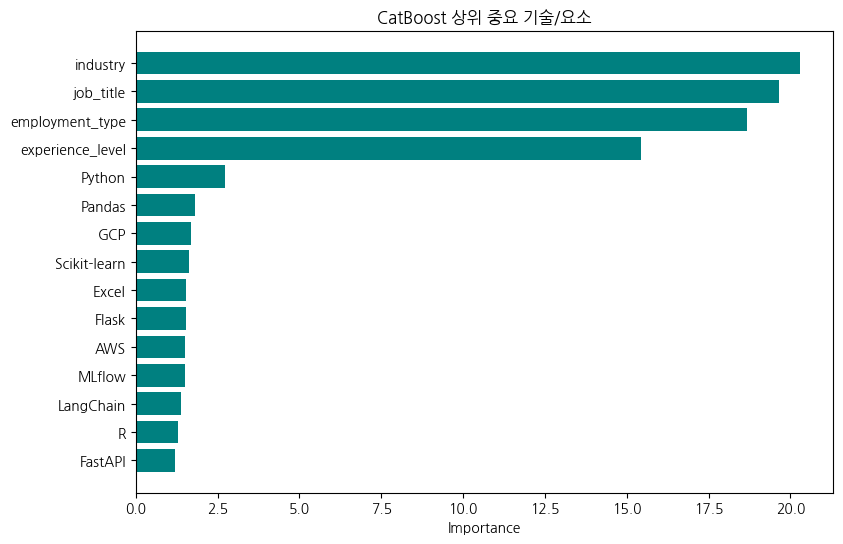


예상 급여 (Python + SQL + AWS): $87,737.82


In [43]:
# =====================================================
# 1. 라이브러리 및 데이터 로드
# =====================================================
# !pip install catboost scikit-learn pandas numpy matplotlib -q

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# -----------------------------------------------------
# 데이터 로드
# -----------------------------------------------------
df = pd.read_csv("ai_job_market_clean.csv")

# -----------------------------------------------------
# skills_required 문자열 → 리스트 변환
# 예: "['Python', 'SQL']" → ['Python', 'SQL']
# -----------------------------------------------------
df['skills_required'] = df['skills_required'].apply(
    lambda x: [skill.strip().replace("'", "") for skill in x.strip("[]").split(",")]
)

# -----------------------------------------------------
# MultiLabelBinarizer로 기술 벡터화
# 각 기술을 독립적인 피처로 변환
# -----------------------------------------------------
mlb = MultiLabelBinarizer()
skills_df = pd.DataFrame(
    mlb.fit_transform(df['skills_required']),
    columns=mlb.classes_
)

# -----------------------------------------------------
# 원본 데이터와 결합
# -----------------------------------------------------
X = pd.concat([
    df[['industry', 'job_title', 'experience_level', 'employment_type']],
    skills_df
], axis=1)

y = df['salary_range_usd']

# -----------------------------------------------------
# 학습/검증 데이터 분리
# -----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------------------
# CatBoost 모델 구성
# -----------------------------------------------------
model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=2000,
    random_seed=42,
    verbose=100,
    loss_function='RMSE'
)

# 범주형 컬럼 인덱스 지정 (숫자형 외 나머지)
cat_features = [0, 1, 2, 3]  # industry, job_title, experience_level, employment_type

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# -----------------------------------------------------
# 모델 학습
# -----------------------------------------------------
print("\nCatBoost 모델 학습 시작...")
model.fit(train_pool, eval_set=test_pool)
print("학습 완료!")

# -----------------------------------------------------
# 평가
# -----------------------------------------------------
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nCatBoost 예측 성능")
print(f"R² Score : {r2:.4f}")
print(f"RMSE     : {rmse:,.2f}")

# -----------------------------------------------------
# 중요 기술 시각화
# -----------------------------------------------------
feature_importances = model.get_feature_importance()
feature_names = X.columns

top_idx = np.argsort(feature_importances)[-15:][::-1]
plt.figure(figsize=(9,6))
plt.barh(feature_names[top_idx], feature_importances[top_idx], color='teal')
plt.title("CatBoost 상위 중요 기술/요소")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

# -----------------------------------------------------
# 예측 예시: 새로운 기술 조합 입력
# -----------------------------------------------------
def predict_salary(industry, job_title, exp_level, emp_type, skills):
    """
    skills: ['Python', 'SQL', 'AWS'] 형태로 입력
    """
    # 기술 피처 생성
    skills_vector = pd.DataFrame([0]*len(mlb.classes_), index=mlb.classes_).T
    for s in skills:
        if s in skills_vector.columns:
            skills_vector[s] = 1

    # 입력 데이터프레임 생성
    input_df = pd.DataFrame({
        'industry': [industry],
        'job_title': [job_title],
        'experience_level': [exp_level],
        'employment_type': [emp_type]
    })
    input_df = pd.concat([input_df, skills_vector], axis=1)

    return model.predict(input_df)[0]

# -----------------------------------------------------
# 예시: Python, SQL, AWS 조합의 예측 급여
# -----------------------------------------------------
predicted_salary = predict_salary(3, 4, 2, 1, ['Python', 'SQL', 'AWS'])
print(f"\n예상 급여 (Python + SQL + AWS): ${predicted_salary:,.2f}")



CatBoost 모델 학습 시작...
0:	learn: 31683.7143320	test: 32577.5017786	best: 32577.5017786 (0)	total: 45.5ms	remaining: 36.4s
100:	learn: 28488.2956161	test: 32539.2682597	best: 32491.2529874 (58)	total: 2.16s	remaining: 14.9s
200:	learn: 24399.0736062	test: 32477.1710506	best: 32467.0255094 (170)	total: 4.37s	remaining: 13s
300:	learn: 20805.1508946	test: 32641.1328454	best: 32467.0255094 (170)	total: 6.34s	remaining: 10.5s
400:	learn: 17998.5708909	test: 32851.4215156	best: 32467.0255094 (170)	total: 8.86s	remaining: 8.82s
500:	learn: 15605.5526894	test: 32893.9883624	best: 32467.0255094 (170)	total: 12.4s	remaining: 7.4s
600:	learn: 13758.9400321	test: 33058.4083448	best: 32467.0255094 (170)	total: 14.5s	remaining: 4.8s
700:	learn: 12192.6819702	test: 33130.1681099	best: 32467.0255094 (170)	total: 16.8s	remaining: 2.37s
799:	learn: 10596.4458997	test: 33233.3381411	best: 32467.0255094 (170)	total: 17.9s	remaining: 0us

bestTest = 32467.02551
bestIteration = 170

Shrink model to first 171

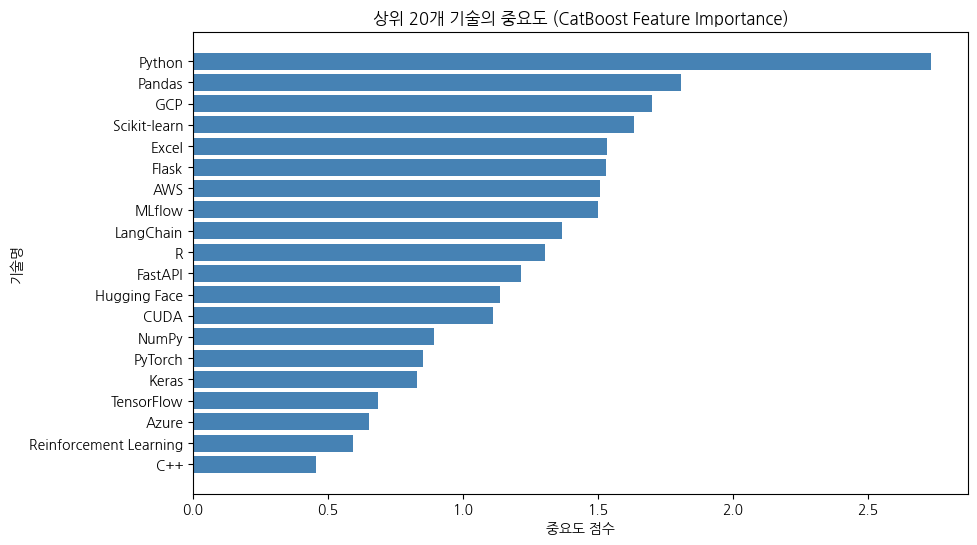

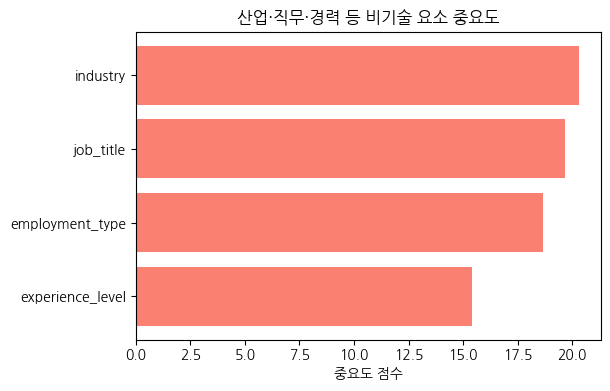


상위 20개 기술 중요도 순위:


,Feature,Importance
4,Python,2.735402
5,Pandas,1.809687
6,GCP,1.702525
7,Scikit-learn,1.634270
8,Excel,1.535743
9,Flask,1.530406
10,AWS,1.509137
11,MLflow,1.501461
12,LangChain,1.369185
13,R,1.302962


In [44]:
# =====================================================
# 1. 라이브러리 및 데이터 로드
# =====================================================
# !pip install catboost scikit-learn pandas numpy matplotlib -q

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# -----------------------------------------------------
# 데이터 불러오기
# -----------------------------------------------------
df = pd.read_csv("ai_job_market_clean.csv")

# -----------------------------------------------------
# skills_required 문자열을 리스트로 변환
# -----------------------------------------------------
df['skills_required'] = df['skills_required'].apply(
    lambda x: [skill.strip().replace("'", "") for skill in x.strip("[]").split(",")]
)

# -----------------------------------------------------
# 기술별 벡터화 (MultiLabelBinarizer)
# -----------------------------------------------------
mlb = MultiLabelBinarizer()
skills_df = pd.DataFrame(
    mlb.fit_transform(df['skills_required']),
    columns=mlb.classes_
)

# -----------------------------------------------------
# skills_required 세분화된 피처 + 기존 피처 결합
# -----------------------------------------------------
X = pd.concat([
    df[['industry', 'job_title', 'experience_level', 'employment_type']],
    skills_df
], axis=1)
y = df['salary_range_usd']

# -----------------------------------------------------
# 학습/테스트 분리
# -----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------------------
# CatBoost 모델 구성
# -----------------------------------------------------
model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=800,
    random_seed=42,
    verbose=100,
    loss_function='RMSE'
)

cat_features = [0, 1, 2, 3]  # industry, job_title, experience_level, employment_type

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# -----------------------------------------------------
# 학습 수행
# -----------------------------------------------------
print("\nCatBoost 모델 학습 시작...")
model.fit(train_pool, eval_set=test_pool)
print("학습 완료!")

# -----------------------------------------------------
# 평가
# -----------------------------------------------------
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n모델 성능\nR²: {r2:.4f}, RMSE: {rmse:,.2f}")

# -----------------------------------------------------
# 피처 중요도 분석
# -----------------------------------------------------
feature_importances = model.get_feature_importance()
feature_names = X.columns

# 중요도 데이터프레임 생성
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# -----------------------------------------------------
# 상위 중요 기술(스킬)만 추출
# -----------------------------------------------------
skills_importance = importance_df[
    importance_df['Feature'].isin(mlb.classes_)
].head(20)  # 상위 20개 기술만 표시

# -----------------------------------------------------
# 시각화
# -----------------------------------------------------
plt.figure(figsize=(10,6))
plt.barh(skills_importance['Feature'], skills_importance['Importance'], color='steelblue')
plt.gca().invert_yaxis()
plt.title("상위 20개 기술의 중요도 (CatBoost Feature Importance)")
plt.xlabel("중요도 점수")
plt.ylabel("기술명")
plt.show()

# -----------------------------------------------------
# 직무·산업 등 범주형 중요도도 함께 표시
# -----------------------------------------------------
category_importance = importance_df[
    importance_df['Feature'].isin(['industry','job_title','experience_level','employment_type'])
]

plt.figure(figsize=(6,4))
plt.barh(category_importance['Feature'], category_importance['Importance'], color='salmon')
plt.gca().invert_yaxis()
plt.title("산업·직무·경력 등 비기술 요소 중요도")
plt.xlabel("중요도 점수")
plt.show()

# -----------------------------------------------------
# 상위 기술 출력
# -----------------------------------------------------
print("\n상위 20개 기술 중요도 순위:")
display(skills_importance)
